In [1]:
from pathlib import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!tree ~/Projects/BitSize_ML/

/Users/nejat/Projects/BitSize_ML/
└── end_to_end_ml
    ├── data
    │   └── housing.csv
    ├── images
    │   └── ENV checking.png
    ├── models
    └── notebooks
        ├── 1_setup.ipynb
        ├── 2_fetch_data.ipynb
        ├── 3_overview_EDA.ipynb
        ├── 4_data_split.ipynb
        ├── 5_stratified_split.ipynb
        └── 6_visualizing_geospatial_data.ipynb

6 directories, 8 files


In [3]:
df_path = Path.cwd().parent /"data"/"housing.csv"
df = pd.read_csv(df_path)

In [4]:
def create_income_bins(df):
    df = df.copy()
    df['income_cat'] = pd.cut(df['median_income'],
                              bins=[0,1.5,3, 4.5,6,np.inf],
                              labels=[1,2,3,4,5])
    return df
df_binned = create_income_bins(df)

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=27)
for train_idx, test_idx in split.split(df_binned,df_binned['income_cat']):
    train_strat = df_binned.loc[train_idx].drop(columns=['income_cat'])
    test_strat = df_binned.loc[test_idx].drop(columns=['income_cat'])
print(f"[Stratified], train_size={len(train_strat)}, test_size={len(test_strat)}")

[Stratified], train_size=16512, test_size=4128


In [6]:
housing = train_strat.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

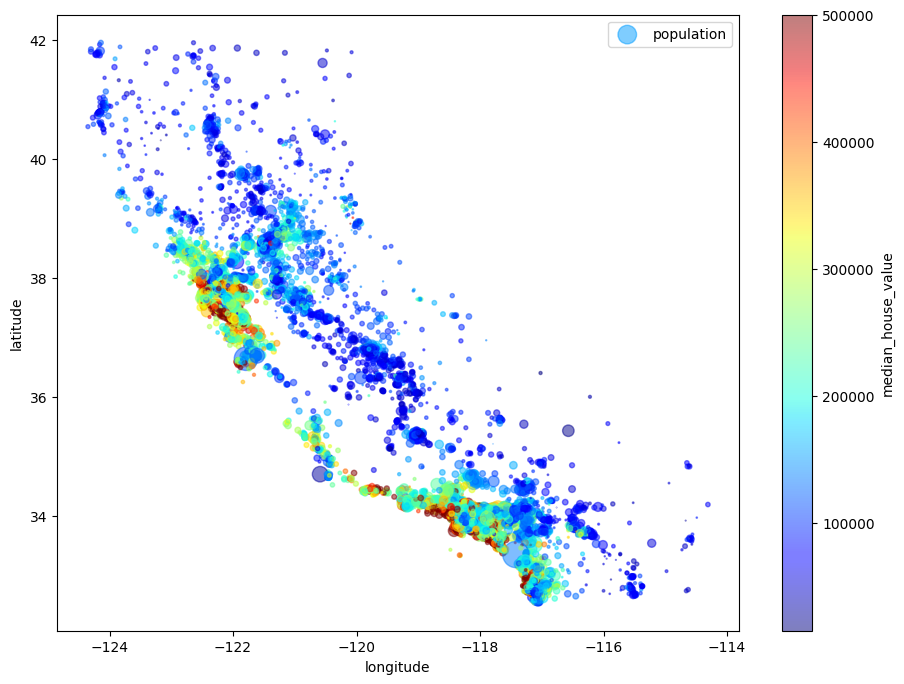

In [17]:
housing.plot(kind="scatter",
             x= "longitude",
             y= "latitude",
             alpha=0.5,
             s = housing['population']/100,
             c = "median_house_value",
             cmap = plt.get_cmap('jet'),
             label = 'population',
             figsize = (11,8))

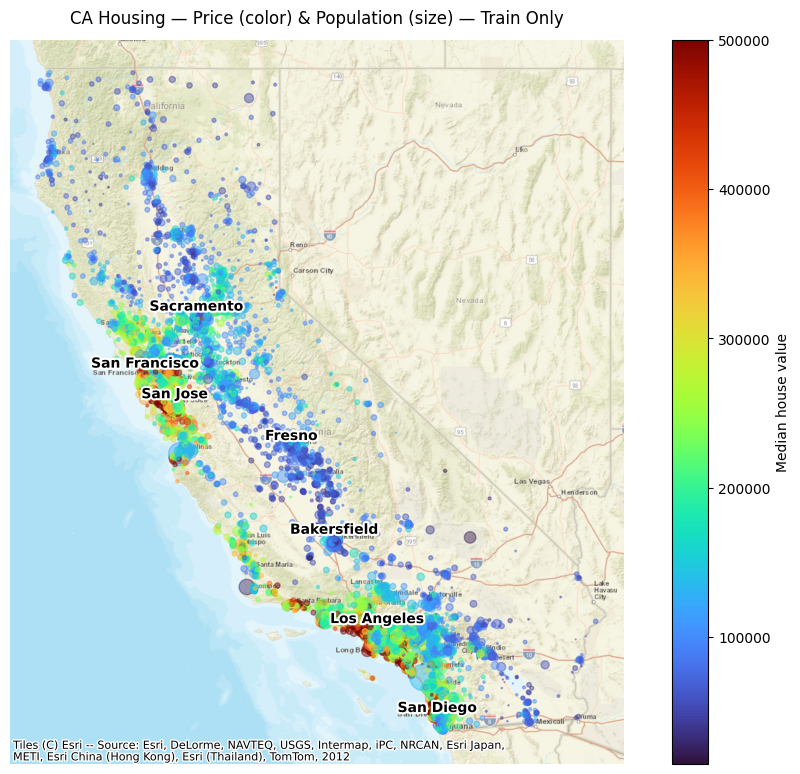

In [18]:
# 🧩 Install required libraries for geographic visualization
# !pip install geopandas contextily

# 📦 Import libraries for mapping, plotting, and text styling
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import contextily as ctx


# 🌍 Create a GeoDataFrame using longitude and latitude as geometry (WGS84 CRS)
gdf = gpd.GeoDataFrame(
    housing,
    geometry=gpd.points_from_xy(housing.longitude, housing.latitude),
    crs="EPSG:4326"
)

# 🗺️ Convert coordinates from WGS84 to Web Mercator (used by most map tiles)
gdf_web = gdf.to_crs(epsg=3857)

# 🖼️ Set up the plot figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# 🎨 Plot housing points — color by median house value, size by population
gdf_web.plot(
    ax=ax,
    column="median_house_value",
    cmap="turbo",
    markersize=gdf_web["population"] / 100,
    alpha=0.45,
    legend=True,
    legend_kwds={"label": "Median house value"}
)

# 🗺️ Add a background basemap for visual context (Esri World Street Map)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap, alpha=0.8)

# 📍 Define key California city coordinates (longitude, latitude)
cities = {
    "San Francisco": (-122.4194, 37.7749),
    "Los Angeles":   (-118.2437, 34.0522),
    "San Diego":     (-117.1611, 32.7157),
    "Sacramento":    (-121.4944, 38.5816),
    "Fresno":        (-119.7871, 36.7378),
    "San Jose":      (-121.8863, 37.3382),
    "Bakersfield":   (-119.0187, 35.3733),
}

# 🔄 Helper function to convert longitude/latitude into Web Mercator coordinates
def lonlat_to_merc(lon, lat):
    pt = gpd.GeoSeries([gpd.points_from_xy([lon], [lat])[0]], crs="EPSG:4326").to_crs(epsg=3857).geometry[0]
    return pt.x, pt.y

# 🏙️ Add city name labels with white outline for readability
for name, (lon, lat) in cities.items():
    x, y = lonlat_to_merc(lon, lat)
    ax.text(
        x, y + 15000, name,
        fontsize=10, fontweight="bold", color="black", ha="center",
        path_effects=[pe.withStroke(linewidth=3, foreground="white")]
    )

# 🚫 Remove axes and ticks for a clean map view
ax.set_axis_off()

# 🏷️ Add a descriptive map title
ax.set_title("CA Housing — Price (color) & Population (size) — Train Only", pad=12)

# 🧹 Adjust layout and display the final map
plt.tight_layout()
plt.show()
